# Notebook for analysis of GAN training. 

This notebook describes how to produce the figures in the article [Producing realistic climate data using GAN](https://npg.copernicus.org/articles/28/347/2021/npg-28-347-2021.html).

One should note that this repository shows the code but due to the size of the dataset the figures were reproduced with reduced dataset. Consequently, the quality of the statistical analysis is impacted. Data were created by running the Plasim simulator, for further details see the article. 

The dataset is composed of the daily images of different variable (temperature, wind components, humidity...) on a 64 by 128 pixel grid with 10 levels of altitude over the globe, projected using the PlateCarre projection. These images were standardized with respect to each variable and each level of altitude, the mean and std are stored in the "scaling" dataset.  

In [1]:
#Import of necessary packages and memory allocation.

%matplotlib inline
import tensorflow as tf
import keras 
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
#config.gpu_options.visible_device_list = str(3)
set_session(tf.Session(config=config))

import h5py as h5
import pandas as pd
from keras.models import load_model
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.util
import sys
import seaborn as sns
import math

/home/besombes/.env/old_tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/besombes/.env/old_tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/besombes/.env/old_tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/besombes/.env/old_tf1/lib/python3.7/site-packages/tensorflow/

/home/besombes/.env/old_tf1/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/besombes/.env/old_tf1/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/besombes/.env/old_tf1/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/besombes/.env/old_tf1/lib/python3.7/site

In [2]:
#Plot parameters.

from matplotlib import rc
sns.set() #Seaborn theme 
font = {'family' : 'normal','weight' : 'bold', 'size'   : 22}
tick_size = 20
fontweight = 'bold'
#lab_loc = 2
#lab_font_size = 14
#rc('text', usetex=True)
matplotlib.rc('font', **font)
plt.style.use('seaborn')

In [3]:
# Paths

data_file = 'data_plasim_3y_sc.h5' # Dataset filename 

## Notebook parameters. 

Setting up parameters for :
  - Figure generation.
  - Number of samples considered for the statistical analysis (Here very low for computational purpose).
  - Longitude and latitude of grid cells.
  - Different names of the GAN training save.

(64, 1)


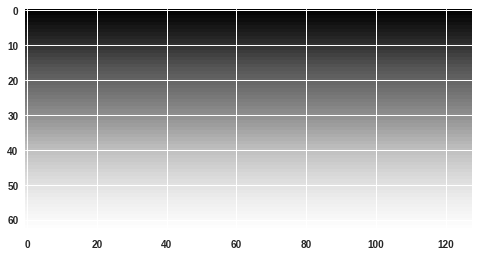

In [4]:
#########
multi_train = True  #If the training was in multiple run : True
plot_var = True     #True: plot all cells result ; False : manualy change if plot_var in if True: to plot
save = False         
scale = False
#########
N_fields = 82      #Number of fields == Number of channels in generated tensor. 
N_lvls = 10         #Number of pressure level for 3D variable. 

N_gen = 100    #Number of generation used for statistic analysis /!\ Memory usage important /!\
N_train = 50
#indxs = np.random.randint(0,1000,N_gen)
#ind = indxs[0]
#########
lons = np.genfromtxt('../data/raw/lon.csv', delimiter=',')
lat = np.genfromtxt('../data/raw/lat.csv', delimiter=',')


lon_idx = [16,16,32,48]                    #France, north america, ecuador, south america
lat_idx = [5,106,106,106]                  #France, north america, ecuador, south america
fnes = [[16,5],[16,106],[32,106],[48,106]] #Coordinate for distribution comparison at different locations.
L_ind = ['a','b','c','d']


if N_fields==82:
    runnumber_0 = 'RESNET_V8_82l'
    runnumber_1, stop1 = 'RESNET_V8_82l_continue1', 8000 #Name of the generator save file for the 1st restart
    runnumber_2, stop2 = 'RESNET_V8_82l_continue2', 15500 #Name of the generator save file for the 2nd restart
    runnumber_3, stop3 = 'RESNET_V8_82l_continue3b', 23250
    runnumber_4, stop4 = 'RESNET_V8_82l_continue4', 31000
    runnumber = runnumber_4 #Most recent save
elif N_fields==22:
    runnumber_0 = 'RESNET_V8_gual_Gbn'
    runnumber = runnumber_0 #Most recent save
    
llat = lat
llat = np.expand_dims(lat, axis = 0)
llat = np.expand_dims(lat, axis = -1)
print(llat.shape)
llat = llat.repeat(128, axis = 1)
plt.imshow(llat)

Here _X_train has a size of (samples, latitude, longitudes, variable). Variable has a size of 82 due to the different variables at differents altitude levels. Below the name of the different channels are printed : ta_z100 is for example the temperature at the pressure level 100 hPa i.e. at the surface. There is 8 different variables on the 10 pressure levels plus the surface pressure.

In [5]:
# Loading dataset and scaling factors (N_fields, 2)= mean and variance for each channel.

f=h5.File(f'../data/raw/{data_file}','r')
_X_train = f['dataset']
scaling = f['scaling'][:,:]
print(scaling.shape)

(81, 2)


In [6]:
var = ['ta', 'ua', 'va', 'hus', 'wap', 'zeta', 'd', 'zg']
lvls = [100, 200,300,400,500,600,700,800,900,1000]

chan_titles = []
for i in var:
    for j in lvls:
        chan_titles.append(i+'_z'+str(j))
chan_titles.append('surface pressure')
#chan_titles.append('latitude')

print(chan_titles)

['ta_z100', 'ta_z200', 'ta_z300', 'ta_z400', 'ta_z500', 'ta_z600', 'ta_z700', 'ta_z800', 'ta_z900', 'ta_z1000', 'ua_z100', 'ua_z200', 'ua_z300', 'ua_z400', 'ua_z500', 'ua_z600', 'ua_z700', 'ua_z800', 'ua_z900', 'ua_z1000', 'va_z100', 'va_z200', 'va_z300', 'va_z400', 'va_z500', 'va_z600', 'va_z700', 'va_z800', 'va_z900', 'va_z1000', 'hus_z100', 'hus_z200', 'hus_z300', 'hus_z400', 'hus_z500', 'hus_z600', 'hus_z700', 'hus_z800', 'hus_z900', 'hus_z1000', 'wap_z100', 'wap_z200', 'wap_z300', 'wap_z400', 'wap_z500', 'wap_z600', 'wap_z700', 'wap_z800', 'wap_z900', 'wap_z1000', 'zeta_z100', 'zeta_z200', 'zeta_z300', 'zeta_z400', 'zeta_z500', 'zeta_z600', 'zeta_z700', 'zeta_z800', 'zeta_z900', 'zeta_z1000', 'd_z100', 'd_z200', 'd_z300', 'd_z400', 'd_z500', 'd_z600', 'd_z700', 'd_z800', 'd_z900', 'd_z1000', 'zg_z100', 'zg_z200', 'zg_z300', 'zg_z400', 'zg_z500', 'zg_z600', 'zg_z700', 'zg_z800', 'zg_z900', 'zg_z1000', 'surface pressure']


## Generator loading

In the following cells the trained generator of the GAN model is loaded. The custom_objects parameter is the custom layers inside the generator that needs to be redefine at the loading. 

In [10]:
sys.path.append('../src/modeling')
sys.path.append('../src/preprocessing')
sys.path.append('../src/preparation')

from custom_classes import NearestPadding2D, WrapPadding2D, ConvSN2D, DenseSN

gen = load_model(f'../model/{runnumber}_generator.h5',
                 custom_objects = {'NearestPadding2D': NearestPadding2D,
                                   'WrapPadding2D': WrapPadding2D,
                                   'DenseSN' :DenseSN,
                                   'ConvSN2D': ConvSN2D})


2022-06-09 10:06:22.437638: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.
/home/besombes/.env/old_tf1/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [12]:
sample =  np.load('../data/generated/wgan/test/test_0.npy')
print(sample.shape)

(2, 64, 128, 82)


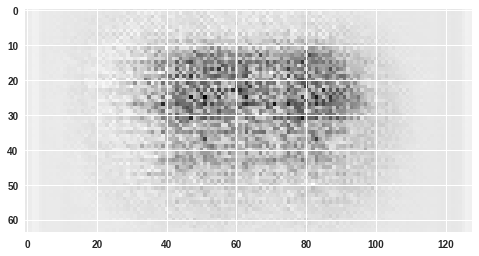

In [13]:
plt.imshow(sample[0,:,:,0])

In [8]:
print('Generating samples...')

z = np.random.normal(0,1,(N_gen,64))
fk_imgs = gen.predict(z)
print('Samples generated.')
print('scaling...')
fk_imgs = np.multiply(fk_imgs[:,:,:,:-1],
                    scaling[np.newaxis,:,1]) + scaling[np.newaxis,:,0]
print('scaled.')

print('Scaling...')
X_train = np.multiply(_X_train[:N_train,:,:,:],
                    scaling[np.newaxis,:,1]) + scaling[np.newaxis,:,0]
print('Scaled')

noise_ = np.load('../data/raw/noise_.npy') # Loads a noise vector studied in the article.
im = gen.predict(noise_)
im_sc = np.multiply(im[:,:,:,:-1],
                    scaling[np.newaxis,:,1]) + scaling[np.newaxis,:,0]

# Add a column at a side of the image to enforce periodic boundary condition 
# at the vertical side of the image.

X_train, lon = cartopy.util.add_cyclic_point(X_train, coord=lons, axis=2)
fk_imgs, lon = cartopy.util.add_cyclic_point(fk_imgs, coord=lons, axis=2)
im, lon = cartopy.util.add_cyclic_point(im, coord=lons, axis=2)
im_sc, lon = cartopy.util.add_cyclic_point(im_sc, coord=lons, axis=2)

Generating samples...
Samples generated.
scaling...
scaled.
Scaling...
Scaled


In [9]:
ind = 10
indx, indf = ind, 0
print(ind)
#fk_imgs=im_sc

10


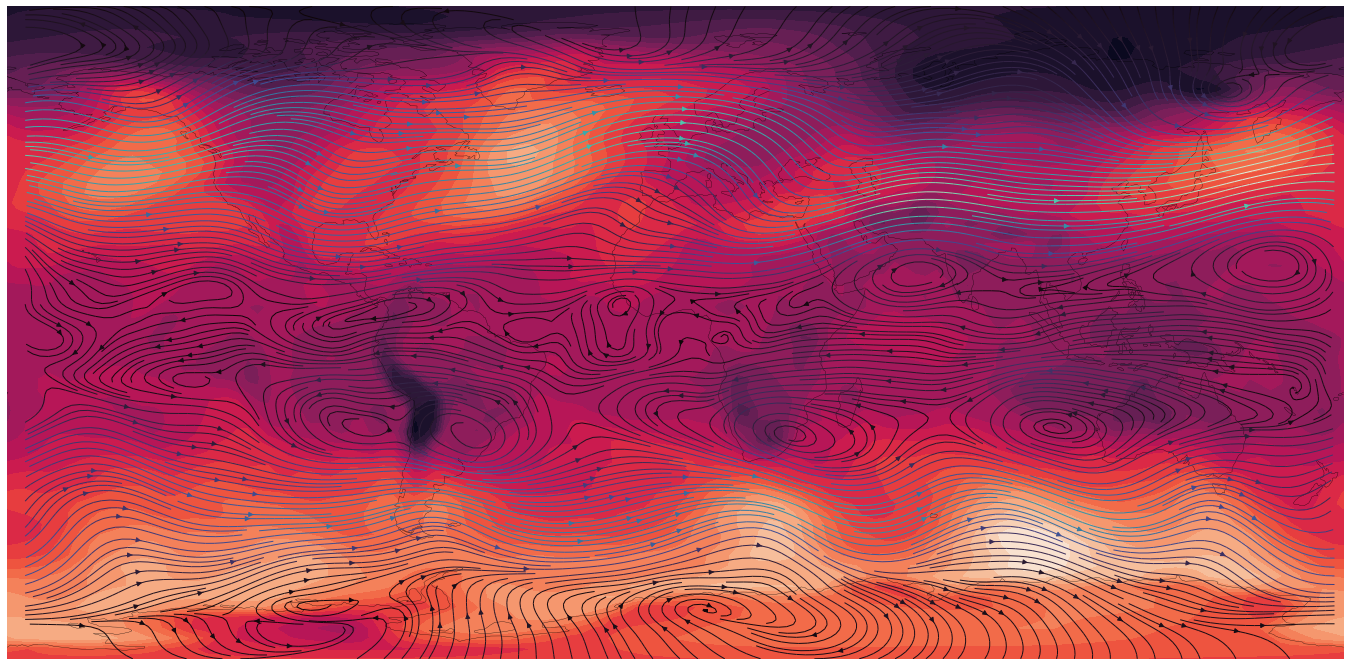

In [10]:
temp_idx = 0
wind_idx = temp_idx+N_lvls
plt.figure(figsize=(24,12))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
ax.coastlines()
plt.contourf(lon, lat, X_train[ind,::,:,temp_idx], levels = 20, cmap = 'rocket')

magnitude = (X_train[ind,:,:,wind_idx] ** 2 + X_train[ind,:,:,wind_idx+N_lvls] ** 2) ** 0.5
sp = plt.streamplot(lon,lat, X_train[ind,:,:,wind_idx], X_train[ind,:,:,wind_idx+N_lvls], cmap = 'mako',
               transform=ccrs.PlateCarree(central_longitude=360.),linewidth=1., density=5., color=magnitude)
im = sp.lines

In [11]:
a = np.random.randint(0,N_gen)

In [12]:
b = np.random.randint(0,N_gen)

## Plot of the contour of the atmopheric fields

# Figures

## Sample from dataset :

[9, 4, 0, 19, 14, 10, 39, 34, 30, 49, 44, 40, 59, 54, 50, 69, 64, 60, 79, 74, 70, -1]


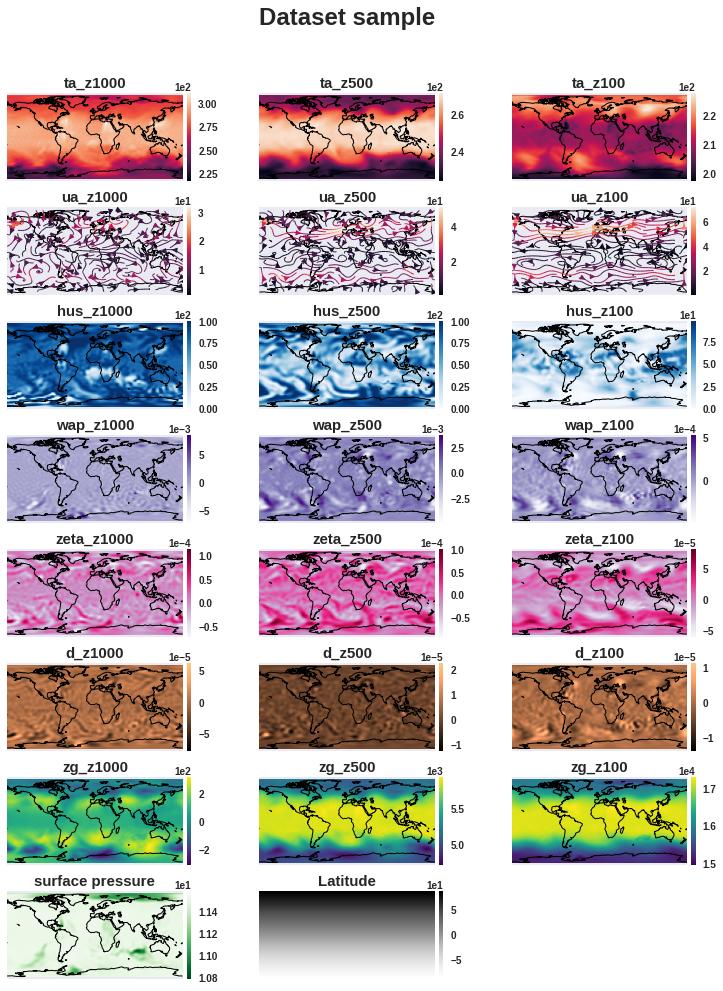

In [13]:

cm = ['rocket','rocket','rocket','rocket','rocket','rocket','Blues','Blues','Blues','Purples','Purples','Purples',
      'PuRd','PuRd','PuRd','copper','copper','copper','viridis','viridis','viridis',
      'Greens_r','Greens_r','Greens_r' ,'Greys']

if N_fields == 22:
    v1,v2,v3 = 0,1,2
    L = [v1, v1+N_lvls, v1+3*N_lvls,
         v2, v2+N_lvls, v2+3*N_lvls,
         v3, v3+N_lvls, v3+3*N_lvls]
elif N_fields == 82:
    v1,v2,v3 = 9,4,0

    L = [v1, v2, v3, v1+N_lvls, v2+N_lvls, v3+N_lvls,
         v1+3*N_lvls, v2+3*N_lvls, v3+3*N_lvls, v1+4*N_lvls, v2+4*N_lvls, v3+4*N_lvls,
         v1+5*N_lvls, v2+5*N_lvls, v3+5*N_lvls, v1+6*N_lvls, v2+6*N_lvls, v3+6*N_lvls,
         v1+7*N_lvls, v2+7*N_lvls, v3+7*N_lvls]

cnt = 1
L.append(-1)
print(L)
fig, ax = plt.subplots(nrows = 8, ncols = 3, figsize=(12,15),
                    subplot_kw={'projection': ccrs.PlateCarree(central_longitude = 0.)})
ax = ax.reshape(1,-1)
fig.suptitle(f'Dataset sample', fontsize = 24, fontweight = fontweight)
fig.subplots_adjust(top = 0.9,left=0.1,right=.9,bottom=0.08, wspace = 0.35, hspace = 0.3)

for k in L:
    ax[0,cnt-1].coastlines(linewidth = 1)
    
    if k in [v1+N_lvls,v2+N_lvls,v3+N_lvls]:
        magnitude = (X_train[ind,:,:,k] ** 2 + X_train[ind,:,:,k+N_lvls] ** 2) ** 0.5
        sp = ax[0,cnt-1].streamplot(lon,lat, X_train[ind,:,:,k], X_train[ind,:,:,k+N_lvls], cmap = 'rocket',
                       transform=ccrs.PlateCarree(central_longitude=180.),linewidth=1, density=1., color=magnitude)
        im = sp.lines
    else:
        im = ax[0,cnt-1].imshow(X_train[ind,::-1,:,k], cmap=cm[cnt-1],
                            transform=ccrs.PlateCarree(central_longitude=180.))

    ax[0,cnt-1].set_title(chan_titles[k], fontsize = 15, fontweight = fontweight)

    posn = ax[0,cnt-1].get_position()
    cax = fig.add_axes([posn.x0 + posn.width + 0.005, posn.y0, 0.005, posn.height])
    cbar = plt.colorbar(im, cax = cax)
    cax.ticklabel_format( axis='both', style='sci',scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
    
    ax[0,cnt-1].grid(False)
    #ax[0,cnt-2].grid(False)
    #ax[0,cnt-3].grid(False)
    #ax[0,cnt-4].grid(False)
    cnt+=1

im = ax[0,-2].imshow(llat)
ax[0,-2].set_title('Latitude', fontsize = 15, fontweight = fontweight)
posn = ax[0,-2].get_position()
cax = fig.add_axes([posn.x0 + posn.width + 0.005, posn.y0, 0.005, posn.height])
cbar = plt.colorbar(im, cax = cax)
cax.ticklabel_format( axis='both', style='sci',scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
ax[0,-1].remove()

if save:
    plt.savefig(f'./fig_{N_fields}c/dataset_sample_subplot.pdf')   
#plt.tight_layout()
#plt.show()

[9, 4, 0, 19, 14, 10, 39, 34, 30, 49, 44, 40, 59, 54, 50, 69, 64, 60, 79, 74, 70, -1]


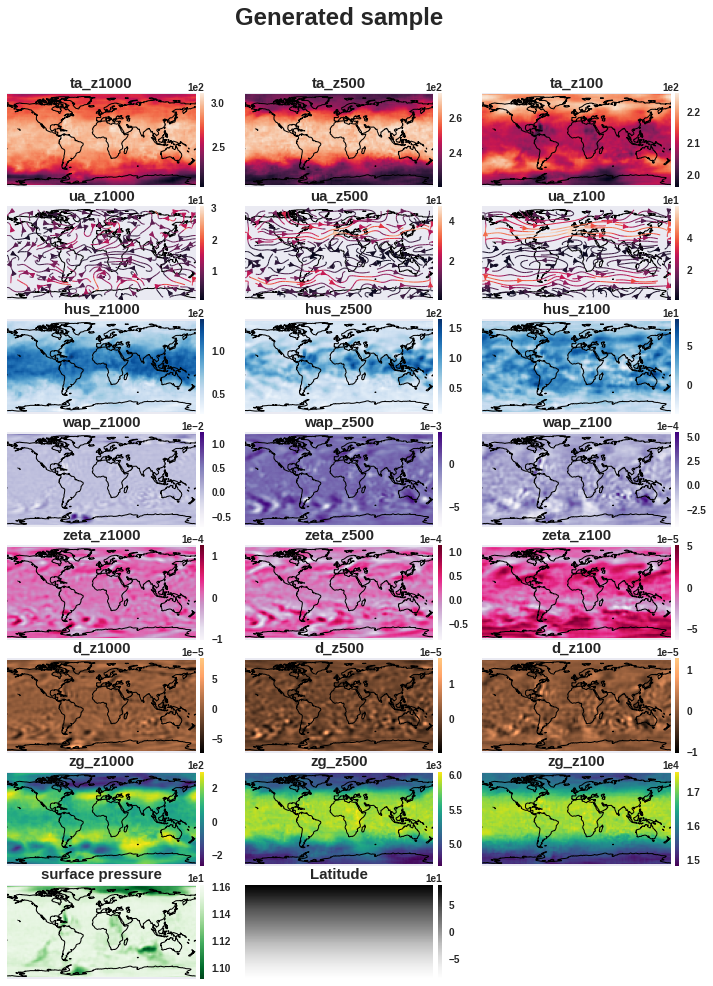

In [14]:
cm = ['rocket','rocket','rocket','rocket','rocket','rocket','Blues','Blues','Blues','Purples','Purples','Purples',
      'PuRd','PuRd','PuRd','copper','copper','copper','viridis','viridis','viridis',
      'Greens_r','Greys']

if N_fields == 22:
    v1,v2,v3 = 0,1,2
    L = [v1, v1+N_lvls, v1+3*N_lvls,
         v2, v2+N_lvls, v2+3*N_lvls,
         v3, v3+N_lvls, v3+3*N_lvls]
elif N_fields == 82:
    v1,v2,v3 = 9,4,0
    L = [v1, v2, v3, v1+N_lvls, v2+N_lvls, v3+N_lvls,
         v1+3*N_lvls, v2+3*N_lvls, v3+3*N_lvls, v1+4*N_lvls, v2+4*N_lvls, v3+4*N_lvls,
         v1+5*N_lvls, v2+5*N_lvls, v3+5*N_lvls, v1+6*N_lvls, v2+6*N_lvls, v3+6*N_lvls,
         v1+7*N_lvls, v2+7*N_lvls, v3+7*N_lvls]

cnt = 1
L.append(-1)

print(L)
fig, ax = plt.subplots(nrows = N_lvls-2, ncols = 3, figsize=(12,15),
                    subplot_kw={'projection': ccrs.PlateCarree(central_longitude = 0.)})
ax = ax.reshape(1,-1)
fig.suptitle(f'Generated sample', fontsize = 24, fontweight = fontweight)
fig.subplots_adjust(top = 0.9,left=0.1,right=.9,bottom=0.08, wspace = 0.1, hspace = 0.20)

for k in L:
    ax[0,cnt-1].coastlines(linewidth = 1)
    
    if k in [v1+N_lvls,v2+N_lvls,v3+N_lvls]:
        magnitude = (fk_imgs[ind,:,:,k] ** 2 + fk_imgs[ind,:,:,k+N_lvls] ** 2) ** 0.5
        sp = ax[0,cnt-1].streamplot(lon,lat, fk_imgs[ind,:,:,k], fk_imgs[ind,:,:,k+N_lvls], cmap = 'rocket',
                       transform=ccrs.PlateCarree(central_longitude=180.),linewidth=1, density=1., color=magnitude)
        im = sp.lines
    else:
        im = ax[0,cnt-1].imshow(fk_imgs[ind,::-1,:,k], cmap=cm[cnt-1],
                            transform=ccrs.PlateCarree(central_longitude=180.))
    
    ax[0,cnt-1].set_title(chan_titles[k], fontsize = 15, fontweight = fontweight)

    posn = ax[0,cnt-1].get_position()
    cax = fig.add_axes([posn.x0 + posn.width + 0.005, posn.y0, 0.005, posn.height])
    cbar = plt.colorbar(im, cax = cax)
    cax.ticklabel_format( axis='both', style='sci',scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
    
    ax[0,cnt-1].grid(False)

    cnt+=1
im = ax[0,-2].imshow(llat)
ax[0,-2].set_title('Latitude', fontsize = 15, fontweight = fontweight)
posn = ax[0,-2].get_position()
cax = fig.add_axes([posn.x0 + posn.width + 0.005, posn.y0, 0.005, posn.height])
cbar = plt.colorbar(im, cax = cax)
cax.ticklabel_format( axis='both', style='sci',scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
ax[0,-1].remove()

if save:
    plt.savefig(f'./fig_{N_fields}c/fake_sample_subplot.pdf')   